# Определение возраста покупателей

**Определение возраста покупателей**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Описание данных**
Данные взяты с сайта ChaLearn Looking at People.

Оригинальный датасет разбит на тестовый, тренировочный и валидационный.
В нашем распоряжении одна папка со всеми изображениями
`/datasets/faces/final_files` и csv-файл `labels.csv` с метками, который содержит две колонки:

- `file_name` - имя файла изображения
- `real_age` - возраст человека на фотографии.

В оригинальном датасете представлены разнообразные изображения с фотографиями людей во весь рост, портретные фотографии. Для каждого изображения авторы также предоставляют соответствующее изображение, которое содержит только изображения лица, вырезанное из исходного изображения, правильно ориентированное (повернутое) с 40% отступом, полученное с помощью детектора лиц Mathias et. al.

В нашем распоряжении уже обработанный датасет с лицами, таким образом, задачу детекции лиц производить не нужно.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

img_path = '/datasets/faces/final_files/'

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_it = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=img_path,
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      seed=12345) 

Found 7591 validated image filenames.


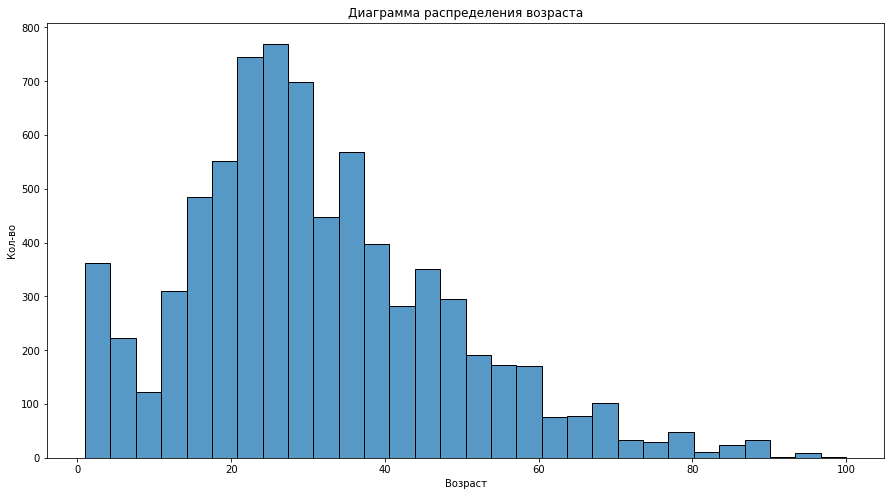

In [3]:
plt.figure(figsize=(15,8))
ax = sns.histplot(labels, bins=30, legend = False)
ax.set_title('Диаграмма распределения возраста')
plt.xlabel('Возраст')
plt.ylabel('Кол-во');

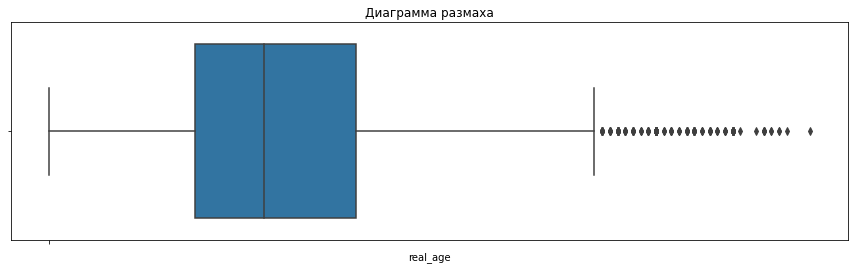

In [4]:
plt.figure(figsize=(15,4))
sns.boxplot(x = labels['real_age'])                        
plt.title(label='Диаграмма размаха')
plt.xticks([1], [''])
plt.show()

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

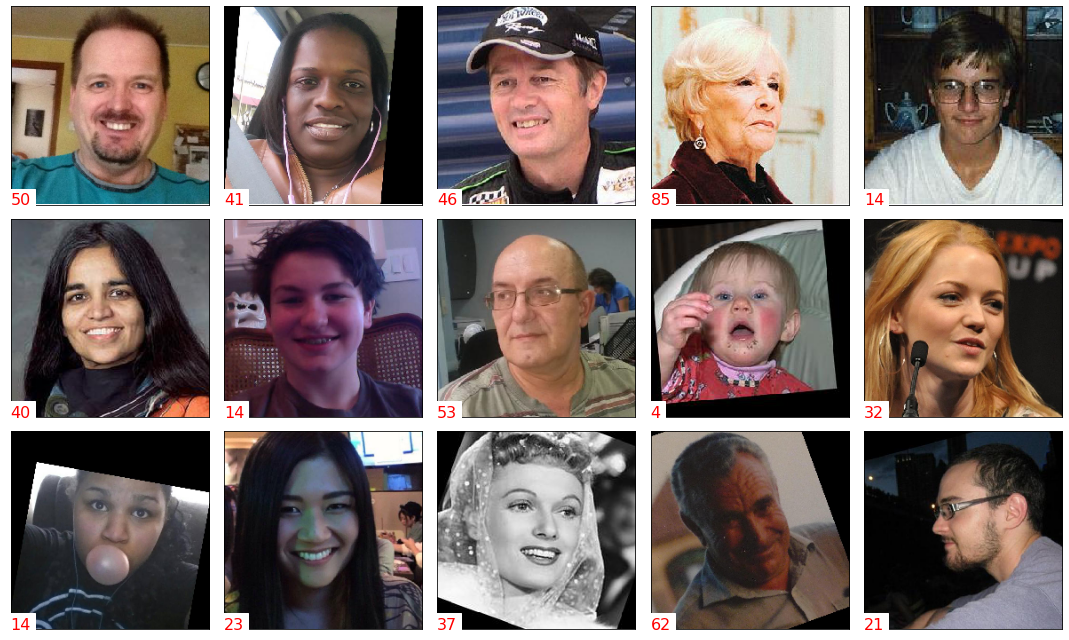

In [6]:
x, y = next(train_it)
fig = plt.figure(figsize=(15,9))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    plt.imshow(x[i])
    plt.text(0, 0, y[i], fontsize = 16, transform=ax.transAxes,
             color='red', backgroundcolor='white')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод**
- Датасет содержит 7591 точек
- Распределение данных имеет вид бимодального распределения с длинных хвостом
- Медиана - 29 лет, верхний ус примерно 70 лет. Это говорит о том, что модель будет обучаться на неравномерно распределенной выборке
- Не на всех фото четкие лица, есть фото в очках и тд., а также черно-белые фото


## Обучение модели

```python

import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_data_gen = ImageDataGenerator(
        rescale = 1. / 255,
        vertical_flip = False,
        validation_split = 0.2
    )

    train_gen_flow = train_data_gen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        subset = 'training',
        seed = 12345
    )

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        rescale = 1. / 255, 
        validation_split = 0.2
    )

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    optimizer = Adam(learning_rate = 0.0001)
    backbone = ResNet50(
        input_shape = input_shape, 
        weights = 'imagenet', 
        include_top = False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation = 'relu'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = optimizer,
        metrics = ['mae']
    )

    return model


def train_model(
    model, 
    train_gen_flow,
    test_gen_flow,
    batch_size = None, 
    epochs = 20,
    steps_per_epoch = None,
    validation_steps = None
):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_gen_flow)
    
    if validation_steps is None:
        validation_steps = len(test_gen_flow)

    model.fit(
        train_gen_flow,
        validation_data = test_gen_flow,
        batch_size = batch_size,
        epochs = epochs,
        validation_steps = validation_steps,
        verbose = 2,
        shuffle = True
    )

    return model 

```

```
Train for 190 steps, validate for 48 steps
Epoch 1/20
190/190 - 50s - loss: 246.6548 - mae: 11.2145 - val_loss: 538.9147 - val_mae: 18.0306
Epoch 2/20
190/190 - 41s - loss: 67.7782 - mae: 6.2451 - val_loss: 618.9034 - val_mae: 19.6905
Epoch 3/20
190/190 - 57s - loss: 32.6234 - mae: 4.4156 - val_loss: 328.8399 - val_mae: 13.3398
Epoch 4/20
190/190 - 49s - loss: 20.8450 - mae: 3.5671 - val_loss: 111.2948 - val_mae: 7.9458
Epoch 5/20
190/190 - 58s - loss: 15.3950 - mae: 3.0602 - val_loss: 76.3967 - val_mae: 6.5800
Epoch 6/20
190/190 - 62s - loss: 11.5724 - mae: 2.6193 - val_loss: 71.8430 - val_mae: 6.4410
Epoch 7/20
190/190 - 63s - loss: 9.7450 - mae: 2.3821 - val_loss: 66.0534 - val_mae: 6.1061
Epoch 8/20
190/190 - 64s - loss: 7.8383 - mae: 2.1343 - val_loss: 67.2302 - val_mae: 6.2559
Epoch 9/20
190/190 - 66s - loss: 7.1332 - mae: 2.0237 - val_loss: 73.5042 - val_mae: 6.3850
Epoch 10/20
190/190 - 66s - loss: 6.9288 - mae: 1.9973 - val_loss: 62.2830 - val_mae: 5.9657
Epoch 11/20
190/190 - 65s - loss: 5.9762 - mae: 1.8506 - val_loss: 65.2732 - val_mae: 6.0736
Epoch 12/20
190/190 - 63s - loss: 6.1302 - mae: 1.8474 - val_loss: 76.6701 - val_mae: 6.4834
Epoch 13/20
190/190 - 62s - loss: 6.4106 - mae: 1.9223 - val_loss: 63.9282 - val_mae: 5.9767
Epoch 14/20
190/190 - 62s - loss: 6.3589 - mae: 1.9134 - val_loss: 68.6017 - val_mae: 6.1435
Epoch 15/20
190/190 - 63s - loss: 6.4968 - mae: 1.9215 - val_loss: 67.2265 - val_mae: 6.2670
Epoch 16/20
190/190 - 61s - loss: 6.7173 - mae: 1.9427 - val_loss: 68.3374 - val_mae: 6.0784
Epoch 17/20
190/190 - 52s - loss: 6.1869 - mae: 1.8774 - val_loss: 66.6959 - val_mae: 6.2041
Epoch 18/20
190/190 - 41s - loss: 5.4257 - mae: 1.7761 - val_loss: 65.7074 - val_mae: 6.2130
Epoch 19/20
190/190 - 54s - loss: 5.0429 - mae: 1.6929 - val_loss: 64.8905 - val_mae: 6.0207
Epoch 20/20
190/190 - 54s - loss: 5.3764 - mae: 1.7336 - val_loss: 65.2923 - val_mae: 6.1080
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 9s - loss: 65.2923 - mae: 6.1080
Test MAE: 6.1080



```

**Изменил размер фотографий и уменьшил кол-во эпох**

## Анализ обученной модели

**Анализ данных:**

Данные распределены не равномерно, медиана 29 лет, основная масса от 20 до 41 года. Имеем более молодое поколение в выборке, а значит модель лучше обучиться на этом возрасте, а большие значения ошибки будут после возраста 70 лет.

**Анализ обученной модели:**

- Обученная свёрточная нейронная сеть ResNet50 показала метрику качества 6.10
- Нейронная сеть ошибается в среднем на 6.5 лет при прогнозе возраста по фото
- Нейронная сеть соответствует поставленной задаче сетевого супермаркета и может быть внедрена в систему слежения, что повысит средний чек покупателей за счет рекомендации потенциально интересных товаров для возрастных групп, а также снизит риск продажи алкоголя и табака несовершеннолетним.